In [26]:
import numpy as np
from scipy.optimize import brentq # Root finding function
import matplotlib.pyplot as plt

# Introduction

In the previous lecture, we proved that the Bellman Operator and the Coleman Operator are commutative. Therefore, the policy functions derived from Euler equation-based methods are theoretically the same as those from value function-based methods.

In this lecture, we apply the Coleman Operator to numerically analyze and simulate the optimal growth model from the previous section. Euler equation-based methods mainly consist of two algorithms:
- **Time Iteration Method**
- **Endogenous Grid Method**

We will explain the main steps and simulation methods of both algorithms. We will find that **Euler equation-based methods are more accurate and faster than value function-based methods**. 

**Therefore, when analyzing the continuous optimal decisions of agents in decentralized economies, Euler equation-based methods are a better choice.**

However, if some agents face discrete choices, we can combine Euler equation-based methods with value function-based methods to achieve both generality and speed.

Recall the optimal growth model

The **sequential form**:

$$
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \\
\text{s.t.} \quad y_{t+1} = f(y_t - c_t) z_{t+1},\forall t \\
0 \leq c_t \leq y_t,\forall t \\
y_0 \quad given
$$


The **Bellman equation**:
$$
v(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int v(f(y - c) z') \phi(dz')
    \right\}
\qquad (y \in \mathbb R_+)
$$


The **Euler equation**:
$$
(u'\circ \sigma^*)(y)
= \beta \int (u'\circ \sigma^*)(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z' \phi(dz')
$$

# **Time Iteration Method**

## **Algorithm**

**1. Generate the Grid**  
   Divide the state space into a discrete grid:  
   $$\{y_i\}_{i=0}^{N} \equiv Grid(y)$$

**2. Set Convergence Criterion**  
   Define a tolerance level `tol > 0` for convergence.

**3. Apply the Coleman Operator**  
   Apply the Coleman operator to any given policy function $\sigma^{(n-1)}(y)$. 

   For each $y_i \in Grid(y)$, solve for $\{c_i\}_{i=0}^{N}$ by finding the solution to the following equation:
   $$
   u'(c_i) - \beta \int (u' \circ \sigma^{(n-1)}) \left( f(y_i - c_i) z' \right) f'(y_i - c_i) z' \phi(dz') = 0
   $$

   The solution $\{c_i\}_{i=0}^{N}$ is then considered as a function of $y$, denoted as $c = \sigma^{(n)}(y)$.

**Notes**:
   - Although $\sigma^{(n)}(y)$ is theoretically a continuous function, the policy function we use is discrete over `Grid(y)`. Since numerical root-finding methods require continuous functions, we use interpolation (`interp`) to ensure the Euler equation is continuous.
   - To compute the expectation in the Euler equation, we use Monte Carlo approximation. The expected value is approximated by taking the average of random samples of $z'$:
   $$
   \frac{1}{N_{z'}} \sum_{z'} \left[ (u' \circ \sigma^{(n-1)}) \left( f(y_i - c_i) z' \right) f'(y_i - c_i) z' \right] \approx
   \int (u' \circ \sigma^{(n-1)}) \left( f(y_i - c_i) z' \right) f'(y_i - c_i) z' \phi(dz')
   $$

   (If the process is Markovian, conditional expectation formulas can be applied instead.)

**4. Check for Convergence**  
   Compute the error between the new and old policy functions:
   $$ error \equiv ||\sigma^{(n)}(y)-\sigma^{(n-1)}(y)|| $$

   - If $error > tol$, go back to Step 3 and use $\sigma^{(n)}(y)$ as the new policy function for the next iteration.
   - If $error < tol$, output the final policy function $\sigma^{(n)}(y)$.


## **1. Inputs**

In the following, we assume the following functions and distributions:

- $ u(c) = \ln c $  
- $ f(k) = k^{\alpha} $  
- $ \phi $ is the distribution of $ z := \exp(\mu + s \zeta) $, where $ \zeta $ is standard normal.

Additionally, we will use a class to store the basic contents of the model. The reason for using a class instead of a function is that a class can store not only parameters and arrays but also functions, making it more versatile than a function.

(Note: Classes are a tool for object-oriented programming and can be used to describe economic agents, a concept we will explore in later lectures.)


In [27]:
class OptimalGrowthModel:
    def __init__(self,                
                α=0.4,          # Production parameter
                β=0.96,         # Discount rate
                μ=0,            # shock location parameter
                s=0.1,          # shock scale parameter
                grid_max=4,     # Maximal value of Grid(y)
                grid_size=120,  # Size of Grid(y)
                shock_size=250, # Size of shock draws
                seed=1234       # Random seed
                ):
        self.α, self.β, self.μ, self.s = α, β, μ, s
        
        # Set the Grid(y)
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Random draw shocks for Montecarlo integration (with a seed)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def f(self,k):
        """Production function"""
        return k**(self.α)
    
    def u(self,c):
        """utility function"""
        return np.log(c)
    
    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))

    def u_prime(self, c):
        "Derivative of u"
        return 1/c
    
    def u_prime_inv(self, c):
        "Derivative of u"
        return 1/c
    

## **2. Euler Residual and Coleman Operator**

We use a function to compute the Euler residual. Given any $c_i$, state value $y_i$, and policy function $\sigma^{(n-1)}(y)$, the function returns the following value:
$$
u'(c_i) - \beta \int (u' \circ \sigma^{(n-1)}) \left( f(y_i - c_i) z' \right) f'(y_i - c_i) z' \phi(dz') \approx \\
u'(c_i) - \beta \frac{1}{N_{z'}} \sum_{z'} \left[ (u' \circ \sigma^{(n-1)}) \left( f(y_i - c_i) z' \right) f'(y_i - c_i) z' \right]
$$


In [28]:
def euler_diff(c,σ,y,model):
    # Unpack the model
    β = model.β
    grid, shocks = model.grid, model.shocks
    u_prime, f, f_prime = model.u_prime, model.f, model.f_prime

    # Turn σ into a continuous function by interpolation
    σ_fun = lambda y: np.interp(y, grid, σ)

    # Calculate the expectation term
    value = u_prime( σ_fun( f(y-c)*shocks ) ) * f_prime(y-c)*shocks
    Expectation = np.mean(value)

    return u_prime(c) - β * Expectation

Next, we define the Coleman Operator `K`.  
Given any policy function $\sigma^{(n-1)}(Y)$, the operator outputs the updated policy function $\{c_i\}_{i=0}^N = \sigma^{(n)}(y)$ after one-step iteration.

In [29]:
def K(σ,model):
    """
    The Coleman-Reffett operator
    """
    # Unpack the model
    β = model.β
    f, f_prime, u_prime = model.f, model.f_prime, model.u_prime
    grid, shocks = model.grid, model.shocks

    #initialize the oprator
    σ_new = np.empty_like(σ)

    for i,y in enumerate(grid):
        # scalar root finding function: qe.optimize.brentq
        c_star = brentq(euler_diff, 1e-10, y-1e-10, args=(σ, y, model))
        σ_new[i] = c_star
    
    return σ_new

Next, we will test whether time iteration can converge to a policy function $\sigma(y)$.

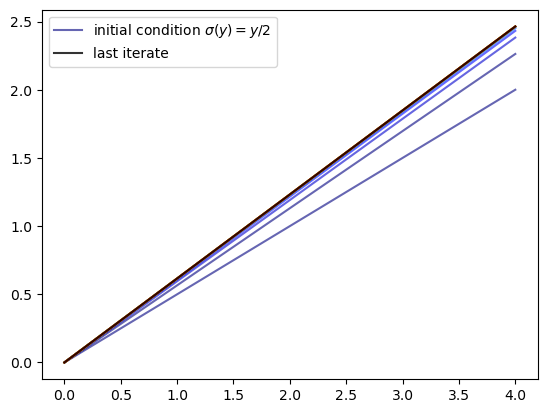

In [30]:
model=OptimalGrowthModel()
n = 15
grid = model.grid
σ = grid/2

fig, ax = plt.subplots()
lb = 'initial condition $\\sigma(y) = y/2$'
ax.plot(grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ, model)
    ax.plot(grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

# Update one more time and plot the last iterate in black
σ = K(σ, model)
ax.plot(grid, σ, color='k', alpha=0.8, label='last iterate')

ax.legend()
plt.show()

## 3. Time Iteration

In [31]:
def time_iter(model,tol=1e-6,max_iter=1000):
    # Unpack the model
    β = model.β
    f, f_prime, u_prime = model.f, model.f_prime, model.u_prime
    grid, shocks = model.grid, model.shocks

    # Initialize the iteration
    iter = 0
    error = tol + 1
    σ = grid/2 # Initial policy function

    # Itration
    while iter<max_iter and error>tol:
        if iter%20==0:
            print(f"Entering iteration {iter} with error {error}.")
        
        # Perform Caleman operator
        σ_new = K(σ,model)
        error = np.max(np.abs(σ_new - σ))
        iter += 1

        # update the policy funtion
        σ[:] = σ_new
        
    print(f"Terminating at iteration {iter} and error {error}.")

    return σ_new

## 4. Get Policy Function

In [32]:
model=OptimalGrowthModel()
σ = time_iter(model,tol=1e-6,max_iter=100)

Entering iteration 0 with error 1.000001.
Terminating at iteration 15 and error 5.337605997191019e-07.


As we can see, the iteration converged after only 15 steps, showing high efficiency. 

Next, let's examine the accuracy of this method.

In fact, this model has a closed-form solution for the policy function:
$$
c^* = \sigma(y) = (1 - \alpha \beta) y
$$

We will create a plot to compare the results.


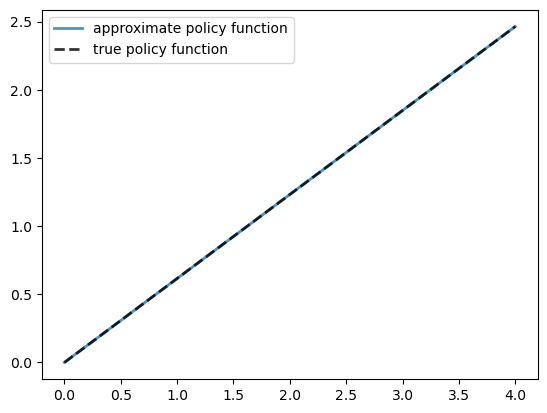

In [33]:
def σ_true(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y
fig, ax = plt.subplots()

ax.plot(model.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(model.grid, σ_true(model.grid, model.α, model.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

## 5. Time-series Simulation

Finally, to simulate the time series, the state transition equation is given by:
$$
y'(y, z') = f(y - c) z' = f(y - \sigma^*(y)) z'
$$

From this, we can see that **even though the policy function $\sigma^*(y)$ is linear, the state transition function is clearly nonlinear.**

In [34]:
def Simulation(σ,model,y0=None,T=200,seed=1234):
    """"
    Simulate time series based on stochastic optimal growth model
    σ: policy function
    model: class of the OG model
    y0: initial condition of output
    T: simulation periods
    seed: random seed
    """
    
    # Unpack
    μ,s = model.μ, model.s
    grid = model.grid
    f = model.f
    
    # Set seed of random number generator
    np.random.seed(seed)
    
    z_sim = np.exp(μ + s * np.random.randn(T))
    y_sim = np.empty(T)
    c_sim = np.empty(T)

    # set the initial conditions
    t = 0
    if y0 == None:
        y_sim[0] = model.grid[20]
    

    # perform simulation
    while t<T-1:    
        c_sim[t] = np.interp(y_sim[t],grid,σ)
        y_sim[t+1] = f(y_sim[t] - c_sim[t])*z_sim[t+1]
        
        t += 1
    
    # Final period
    c_sim[T-1] = np.interp(y_sim[T-1],grid,σ)
    
    return z_sim, c_sim, y_sim

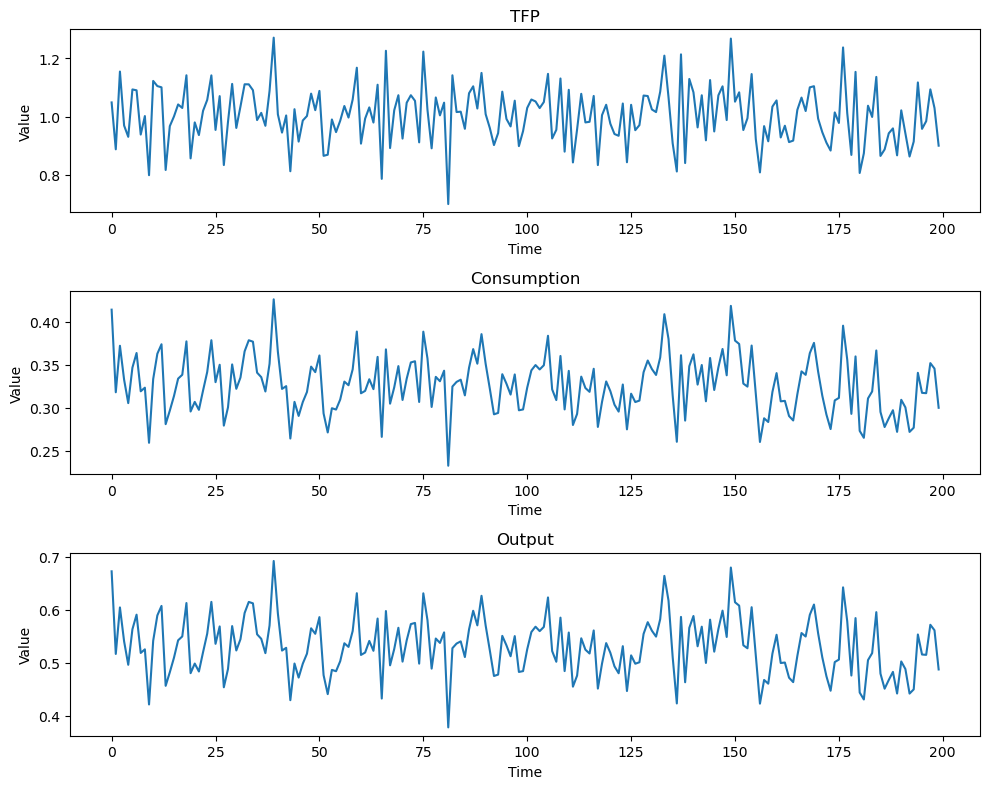

In [35]:
z_sim, c_sim, y_sim = Simulation(σ,model)
time = np.arange(z_sim.size)

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(time, z_sim)
axs[0].set_title('TFP')

axs[1].plot(time, c_sim)
axs[1].set_title('Consumption')

axs[2].plot(time, y_sim)
axs[2].set_title('Output')

# x axis label
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# **Endogenous Grid Method**

In the above calculations, we used a root-finding approach to search for $c_i$ that minimizes the Euler residual for a given $y_i$. 

However, root-finding can consume a significant amount of memory. If we divide `Grid(y)` too finely, even with fewer iterations, the process can become very time-consuming. 

Carroll (2006) suggests that **if the state variables are endogenously chosen, we can use an alternative method to improve efficiency.**

**An additional assumption we need to make is that $u'(c)$ is invertible within its domain.**

## **Algorithm**

**1. Generate the Grid**  
Divide the space of control variable $k$ into a discrete grid:  
$$
\{k_i\}_{i=0}^{N_k} \equiv Grid(k) \\
\text{where} \quad k_i = y_i - c_i
$$

**2. Set Convergence Criterion**  
Define a tolerance level `tol > 0` for convergence.

**3. Apply the Coleman Operator**  
Given any policy function $\sigma^{(n-1)}(y)$, for all $k_i \in Grid(k)$, solve:
$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ \sigma^{(n-1)}) \left( f(k_i) z \right) f'(k_i) z \, \phi(dz)
\right\}
$$
to find the set of $\{c_i\}_{i=0}^{N_k}$ that satisfies the Euler equation, which we define as $\sigma^{(n)}(y)$.

**Notes:**  
- When computing $c_i$, we still need to interpolate $\sigma^{(n-1)}(y)$ to make it a continuous function.  
  It is also necessary to calculate the corresponding endogenous grid for $\sigma^{(n-1)}(y)$.  
  Since $y_i = c_i + k_i$, the grid for $y$ becomes $Grid(y) = \sigma^{(n-1)}(y) + Grid(k)$.

**4. Check for Convergence**  
Compute the error between the new and old policy functions:
$$
error \equiv ||\sigma^{(n)}(y)-\sigma^{(n-1)}(y)||
$$

- If $error > tol$, return to Step 3 and use $\sigma^{(n)}(y)$ as the new policy function for the next iteration.
- If $error < tol$, calculate the endogenous grid $Grid(y) = \sigma^{(n)}(y) + Grid(k)$ and output $\sigma^{(n)}(y)$.

The name "Endogenous Grid Method" (EGM) comes from the fact that the grid for the state variable is endogenously determined by the algorithm.


## **1. Inputs**  
*(Skip: We use the same inputs as in the Time Iteration method.)*

## **2. Coleman Operator of EGM**

In [36]:
def K_EGM(σ, model):
    """
    The Coleman-Reffett operator using EGM

    """

    # Simplify names
    f, β = model.f, model.β
    f_prime, u_prime = model.f_prime, model.u_prime
    u_prime_inv = model.u_prime_inv
    grid, shocks = model.grid, model.shocks
    # warnning: the grid here is Grid(k)

    # Determine endogenous grid
    # y_i = k_i + c_i
    y_grid = grid + σ

    # Linear interpolation of policy using endogenous grid
    σ_fun = lambda y: np.interp(y, y_grid, σ)

    # Allocate memory for new consumption array
    c = np.empty_like(grid)

    # Solve for updated consumption value
    for i, k in enumerate(grid):
        vals = u_prime(σ_fun(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(β * np.mean(vals))

    return c

## **3. Time Iteration**

In [37]:
def time_iter(model,tol=1e-6,max_iter=1000):
    # Unpack the model
    grid = model.grid
    # warnning: this is Grid(k).

    # Initialize the iteration
    iter = 0
    error = tol + 1
    σ = grid/2 # Initial policy function

    # Itration
    while iter<max_iter and error>tol:
        if iter%20==0:
            print(f"Entering iteration {iter} with error {error}.")
        
        # Perform Caleman operator
        σ_new = K_EGM(σ,model)
        error = np.max(np.abs(σ_new - σ))
        iter += 1

        # update the policy funtion
        σ[:] = σ_new

    # Endogenous Grid
    grid_y = σ_new + grid
    print(f"Terminating at iteration {iter} and error {error}.")

    return σ_new,grid_y

## **4. Get Policy function**

In [38]:
model_2 = OptimalGrowthModel()
σ_EGM,grid_y = time_iter(model_2,tol=1e-6,max_iter=1000) 
#much faster than time iteration

Entering iteration 0 with error 1.000001.
Terminating at iteration 18 and error 7.491788691638135e-07.


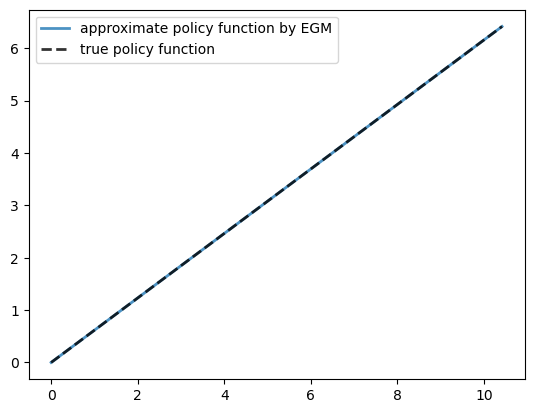

In [39]:
# Draw the graph

fig, ax = plt.subplots()

ax.plot(grid_y, σ_EGM, lw=2,
        alpha=0.8, label='approximate policy function by EGM')

ax.plot(grid_y, σ_true(grid_y, model.α, model.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()